[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [7]:
from langchain_openai import ChatOpenAI
model_ = ChatOpenAI(model="gpt-4o",temperature=0)
from dotenv import load_dotenv
from langchain_groq import ChatGroq
import os

# Charge les variables d'environnement depuis le fichier .env
load_dotenv()

# Récupère ta clé d'API Groq
api_key = os.getenv("GROQ_API_KEY")

# Initialisation du modèle ChatGroq avec ton modèle préféré
model = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0,
    api_key=api_key
)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [8]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [10]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [18]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    print(f"Les messages passés : {messages}")
    response = model.invoke(messages)
    print(f"La reponse est : {response.content}")
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [19]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

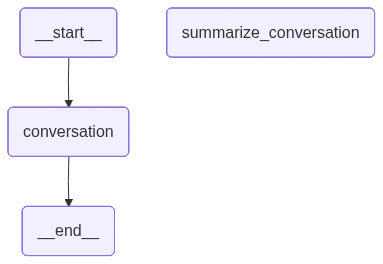

In [26]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! Nice to meet you! Is there something I can help you with or would you like to chat?
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! Nice to meet you! Is there something I can help you with or would you like to chat?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Lance! You told me that when we started chatting. How's your day going so far, Lance?
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================


: 

In [22]:
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! Nice to meet you! Is there something I can help you with or would you like to chat?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Lance! You told me that when we started chatting. How's your day going so far, Lance?
================================ Human Message =================================

i like the 49ers!
================================== Ai Message ==================================

Go Niners! The San Francisco 49ers have a rich history and a loyal fan base. Who's your favorite player, past or present? Are you a fan of the current team or do you have a favorite player from the past, like Joe Montana or Jerry Rice?


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [23]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [24]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

Les messages passés : [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='9abe6ef2-ba92-48dd-9c0b-132736aebd00'), AIMessage(content='Hi Lance! Nice to meet you! Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 14, 'total_tokens': 38, 'completion_time': 0.054934675, 'prompt_time': 0.000315895, 'queue_time': 0.09167848, 'total_time': 0.05525057}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--68d694c0-c16e-4c7c-aeb5-19081033439e-0', usage_metadata={'input_tokens': 14, 'output_tokens': 24, 'total_tokens': 38}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='b59ee61a-18f4-46fd-956a-66de3c2dfc42'), AIMessage(content="Your name is Lance! You told me that when we started 

In [14]:
graph.get_state(config).values.get("summary","")

"Lance introduced himself and mentioned that he is a fan of the San Francisco 49ers. He specifically likes Nick Bosa and inquired if Bosa is the highest-paid defensive player. I confirmed that Nick Bosa signed a record-breaking contract extension in September 2023, making him the highest-paid defensive player at that time, and acknowledged Bosa's talent and Lance's enthusiasm for the player."

## LangSmith

Let's review the trace!